In [285]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from plotly.subplots import make_subplots

In [286]:
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

Evaluation uses relevant metrics and applies (repeated/nested) cross validation appropriately. Hyperparameter tuning is done, and models are clearly compared and interpreted.

# Loading data

In [287]:
df = pd.read_csv('./dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
pio.templates.default = "plotly_white"

# Data description

In [288]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


There are 7043 rows with 21 fields

In [289]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(7043, 21)

SeniorCitizen and tenure are integer. MonthlyCharges, TotalCharges are float. Need to convert them to right type.

In [290]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [291]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

customerId is unique key, useless for model. remove it

In [292]:
df = df.drop(['customerID'], axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Missing value

Convert TotalCharges to integer. if value is empty, be NULL.

In [293]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [294]:
df[np.isnan(df['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


totalCharges is 0 while tenure must be 0. drop invalid value

In [295]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)

Impute totalCharges with mean value

In [296]:
df.fillna(df['TotalCharges'].mean(), inplace=True)

In [297]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [298]:
df["SeniorCitizen"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})

In [299]:
df["InternetService"].describe()

count            7032
unique              3
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

In [300]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


# Visualization

## Gender and churn distribution

In [301]:
# Create individual pie charts with px
fig_gender = px.pie(df, names='gender', title='Gender')
fig_churn = px.pie(df, names='Churn', title='Churn')

# Create subplots
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])

# Add traces from px figures
fig.add_trace(fig_gender.data[0], row=1, col=1)
fig.add_trace(fig_churn.data[0], row=1, col=2)

# Update for donut style
fig.update_traces(hole=0.4, hoverinfo="label+percent+name", textfont_size=16)

# Better title and annotations
fig.update_layout(
    title_text="Gender and Churn Distributions",
    title_x=0.5,
    annotations=[
        dict(text='Gender', x=0.18, y=0.5, font_size=20, showarrow=False),
        dict(text='Churn', x=0.82, y=0.5, font_size=20, showarrow=False)
    ],
    font=dict(size=14)
)

fig.show()

## Churn rate by gender

In [302]:
df[df["Churn"] == "No"]["gender"].value_counts()

gender
Male      2619
Female    2544
Name: count, dtype: int64

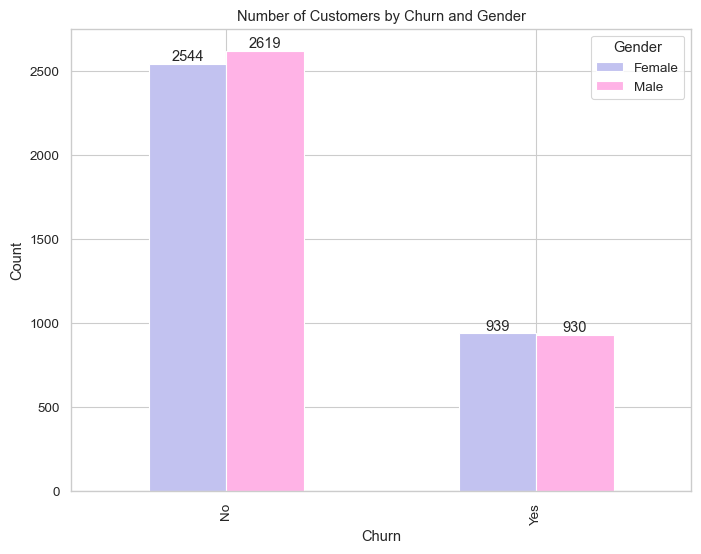

In [303]:
churn_gender_counts = pd.crosstab(df['Churn'], df['gender'])

ax = churn_gender_counts.plot(kind='bar', color=['#c2c2f0', '#ffb3e6'], figsize=(8, 6))
ax.set_ylabel('Count')
ax.set_title('Number of Customers by Churn and Gender')
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title='Gender')
plt.show()

## Contract distribution

In [304]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## Payment Method Distribution

In [305]:
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

## Payment for Churn

In [306]:
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="Customer Payment Method distribution w.r.t. Churn")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## Internet Service and Gender of Churn

In [307]:
df["InternetService"].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [308]:
df[df["gender"] == "Male"][["InternetService", "Churn"]].value_counts()

InternetService  Churn
DSL              No       992
Fiber optic      No       910
No               No       717
Fiber optic      Yes      633
DSL              Yes      240
No               Yes       57
Name: count, dtype: int64

In [309]:
fig = go.Figure()

# Define categories
churn_labels = ['Churn:No', 'Churn:Yes']
genders = ['Female', 'Male']

# Data: [ [DSL_F, DSL_M], [Fiber_F, Fiber_M], [NoInternet_F, NoInternet_M] ] per churn group
data = {
    'DSL': {
        'Churn:No': [965, 992],
        'Churn:Yes': [219, 240]
    },
    'Fiber optic': {
        'Churn:No': [889, 910],
        'Churn:Yes': [664, 633]
    },
    'No Internet': {
        'Churn:No': [690, 717],
        'Churn:Yes': [56, 57]
    }
}

# Build x-axis labels: "Churn:No-Female", "Churn:No-Male".
x_labels = [f"{churn}-{gender}" for churn in churn_labels for gender in genders]

# Add a trace for each InternetService (stacked)
for service, churn_data in data.items():
    y_values = []
    for churn in churn_labels:
        y_values.extend(churn_data[churn])  # [F, M] for this churn group
    fig.add_trace(go.Bar(
        x=x_labels,
        y=y_values,
        name=service,
        text=y_values,
        textposition='auto'
    ))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

## Dependents churn distribution

In [310]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>",
                   color_discrete_map=color_map, text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## Partner Churn

In [311]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>",
                   color_discrete_map=color_map, text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## SeniorCitizen distribution

In [312]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="SeniorCitizen", title="<b>Chrun distribution w.r.t. Senior Citizen</b>",
                   color_discrete_map=color_map, text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## Online security churn

In [313]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>",
                   color_discrete_map=color_map, text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## paperless billing

In [314]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="PaperlessBilling", title="<b>Chrun distribution w.r.t. Paperless Billing</b>",
                   color_discrete_map=color_map, text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

## TechSupport distribution

In [315]:
fig = px.histogram(df, x="Churn", color="TechSupport", barmode="group",
                   title="<b>Chrun distribution w.r.t. TechSupport</b>", text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [316]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>",
                   color_discrete_map=color_map, text_auto=True)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

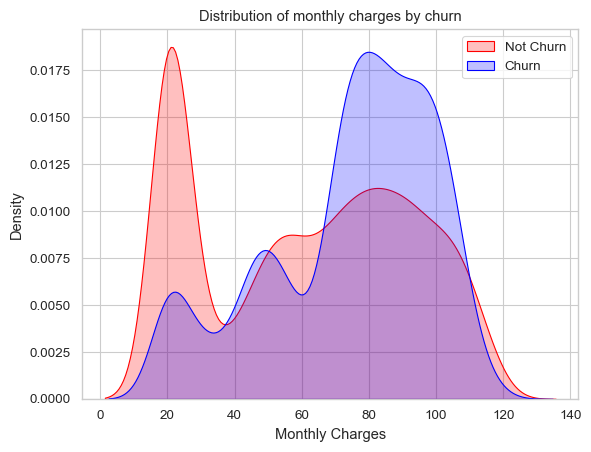

In [317]:
sns.set_context("paper", font_scale=1.1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No')],
                 color="Red", fill=True)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes')],
                 ax=ax, color="Blue", fill=True)
ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

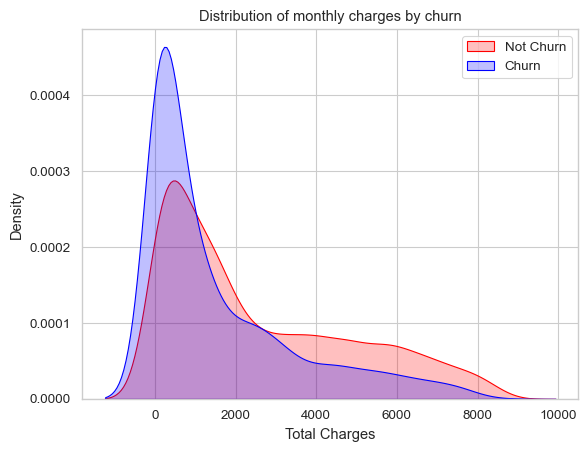

In [318]:
sns.set_context("paper", font_scale=1.1)
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No')],
                 color="Red", fill=True)
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes')],
                 ax=ax, color="Blue", fill=True)
ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of monthly charges by churn')

In [319]:
fig = px.box(df, x='Churn', y='tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
                  title_font=dict(size=25, family='Courier'),
                  title='Tenure vs Churn',
                  )

fig.show()

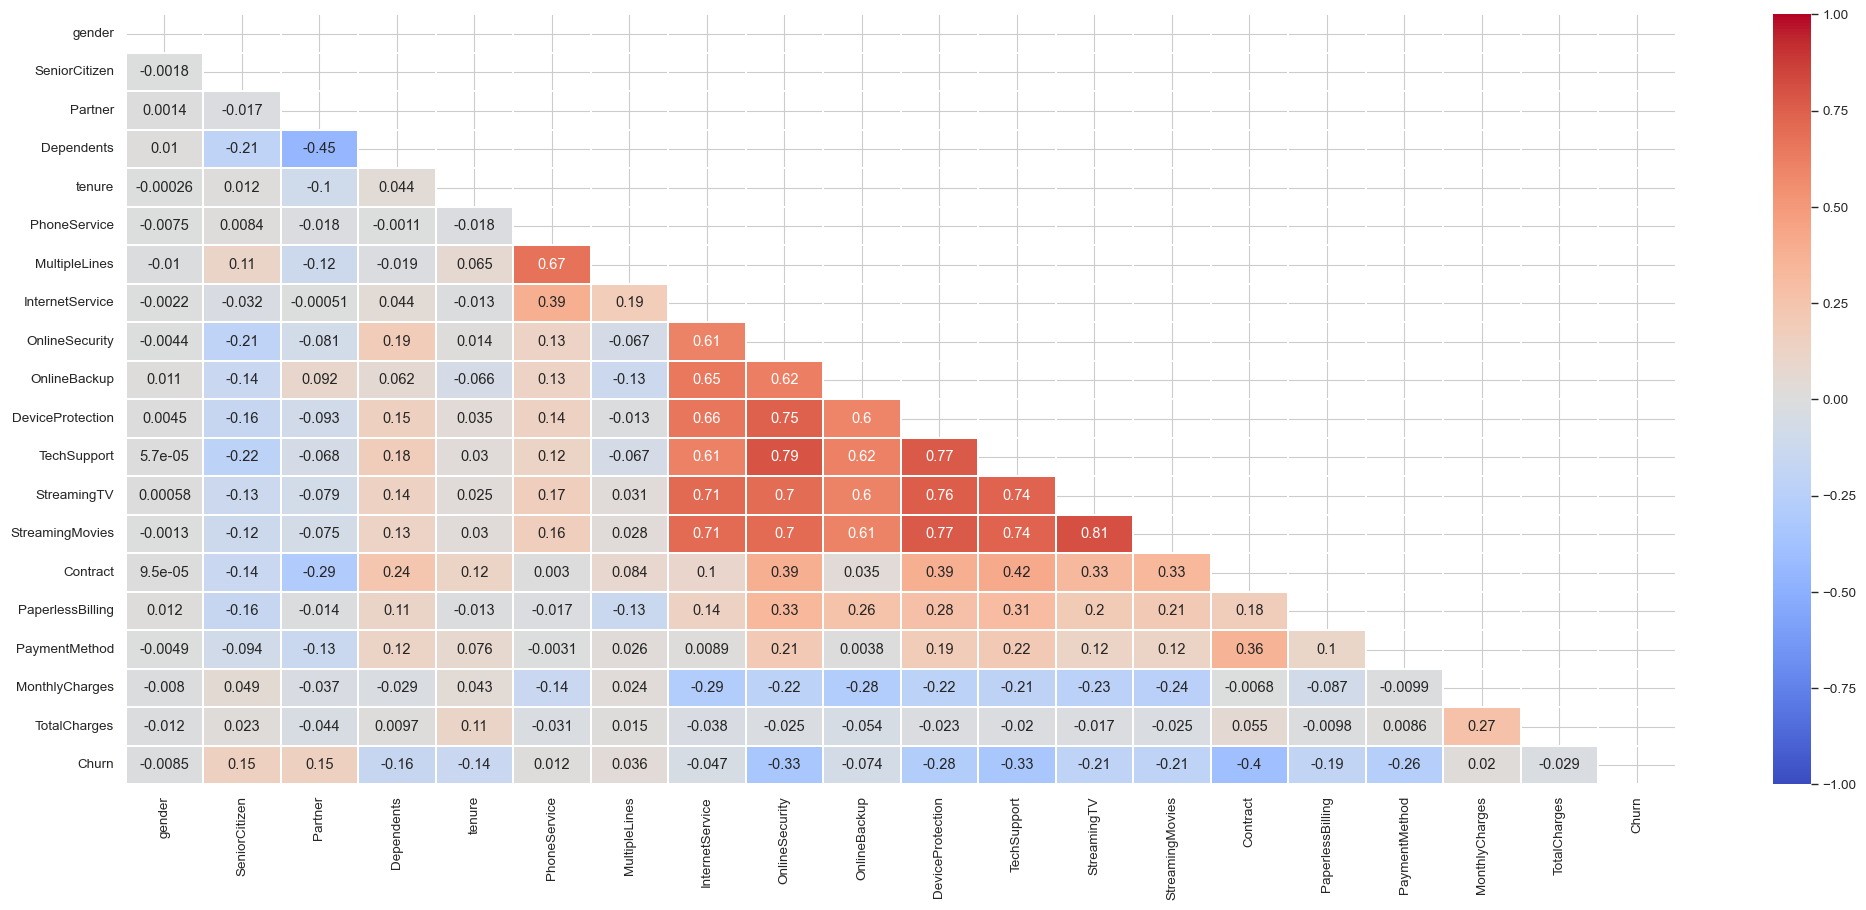

In [320]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2,
                 cmap='coolwarm', vmin=-1, vmax=1)

# Data preprocessing

Unique values of each fields

In [321]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [322]:
for col in df.columns:
    n_unique = df[col].nunique(dropna=True)
    if n_unique < 5:
        uniques = df[col].dropna().unique()
        print(f"{col}: {list(uniques)}")

gender: ['Female', 'Male']
SeniorCitizen: ['No', 'Yes']
Partner: ['Yes', 'No']
Dependents: ['No', 'Yes']
PhoneService: ['No', 'Yes']
MultipleLines: ['No phone service', 'No', 'Yes']
InternetService: ['DSL', 'Fiber optic', 'No']
OnlineSecurity: ['No', 'Yes', 'No internet service']
OnlineBackup: ['Yes', 'No', 'No internet service']
DeviceProtection: ['No', 'Yes', 'No internet service']
TechSupport: ['No', 'Yes', 'No internet service']
StreamingTV: ['No', 'Yes', 'No internet service']
StreamingMovies: ['No', 'Yes', 'No internet service']
Contract: ['Month-to-month', 'One year', 'Two year']
PaperlessBilling: ['Yes', 'No']
PaymentMethod: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn: ['No', 'Yes']


## Encoding

encode categorical fields with one-hot. Binary fields use 0/1 to replace.

In [323]:
binary_cols = ['Partner', 'Dependents', 'PhoneService',
               'PaperlessBilling', 'Churn', 'SeniorCitizen']

for col in binary_cols:
    df[col] = df[col].map({'No': 0, 'Yes': 1})

df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

categorical_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

Set Churn as benchmark, calculate the correlation of each field.

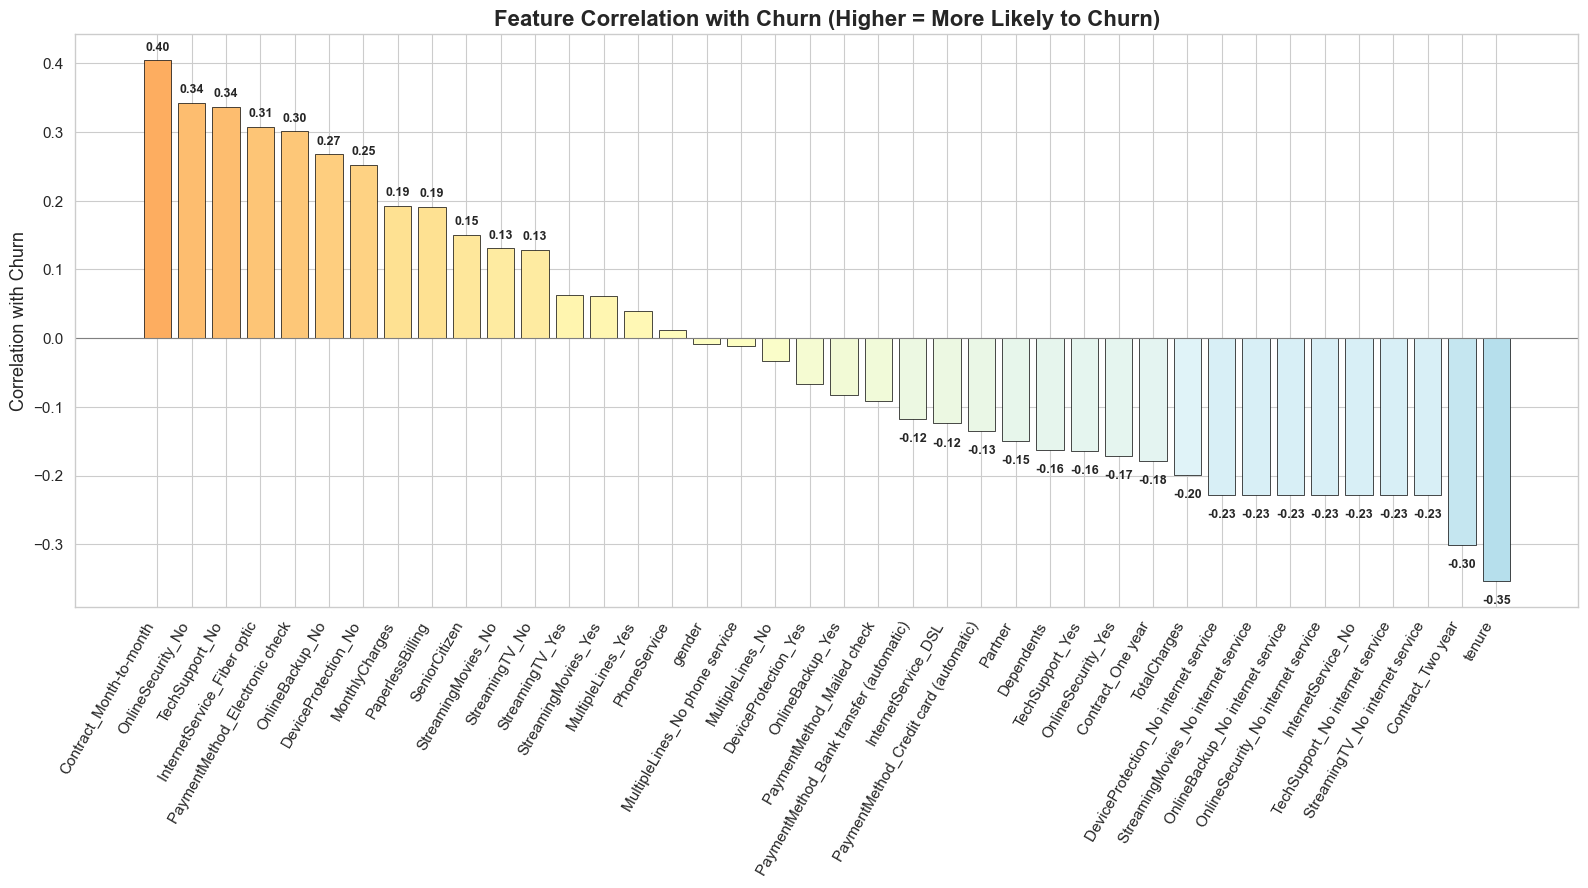

In [324]:
# Get Churn correlations
churn_corr = df.corr()['Churn'].sort_values(ascending=False)
churn_corr = churn_corr.drop('Churn')

# Create figure
plt.figure(figsize=(16, 9))

# Use a diverging colormap: red (positive), white (0), blue (negative)
colors = plt.cm.RdYlBu_r((churn_corr + 1) / 2)  # Normalize to [0,1] for colormap

# Plot
bars = plt.bar(churn_corr.index, churn_corr.values, color=colors, edgecolor='black', linewidth=0.5)

# Rotate x-axis labels for readability
plt.xticks(rotation=60, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Labels and title
plt.ylabel('Correlation with Churn', fontsize=13)
plt.title('Feature Correlation with Churn (Higher = More Likely to Churn)', fontsize=16, weight='bold')

# Add horizontal line at 0
plt.axhline(0, color='gray', linewidth=0.8)

# Optional: Add value labels on bars (only for strong correlations to avoid clutter)
for bar, corr in zip(bars, churn_corr.values):
    if abs(corr) > 0.1:  # Only label if |correlation| > 0.1
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (0.01 if bar.get_height() >= 0 else -0.02),
            f'{corr:.2f}',
            ha='center', va='bottom' if bar.get_height() >= 0 else 'top',
            fontsize=9, fontweight='bold'
        )

plt.tight_layout()
plt.show()

## Split train/test set

In [325]:
y = df['Churn'].values
X = df.drop(columns=['Churn'])

Split data to train/test set with 0.7 rate.

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40, stratify=y)

In [327]:
def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8, 3))
    plt.title("Distribution for {}".format(feature))
    sns.histplot(frame[feature], color=color)

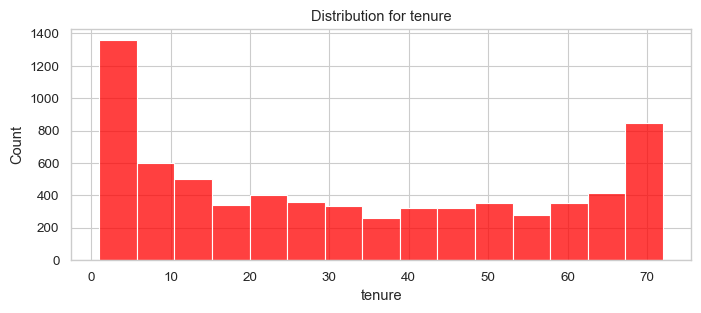

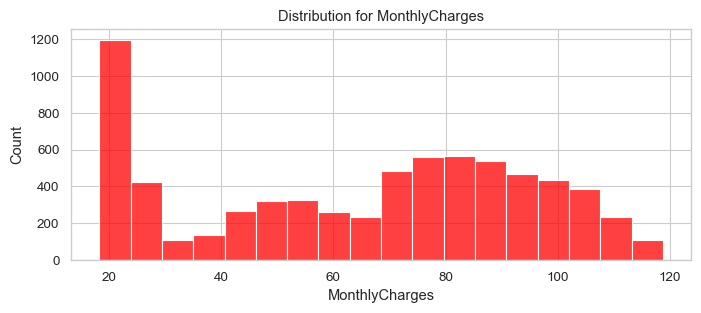

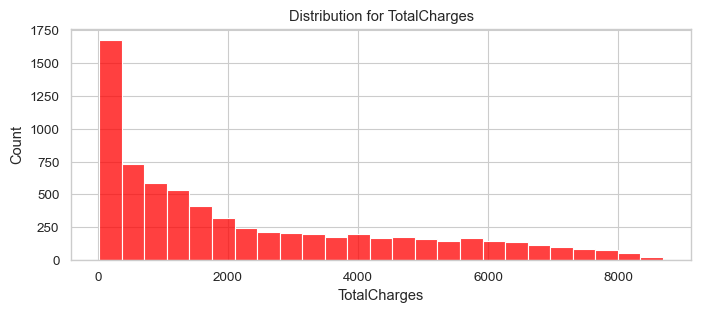

In [328]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df)

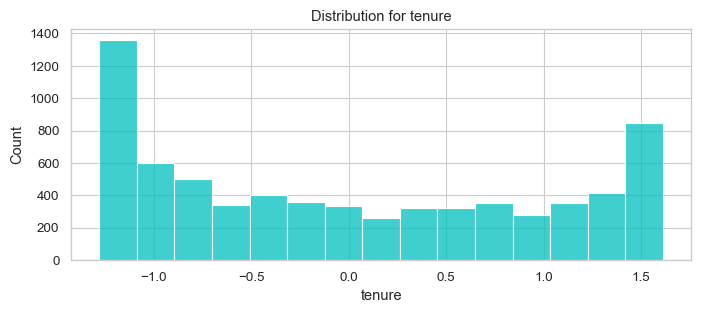

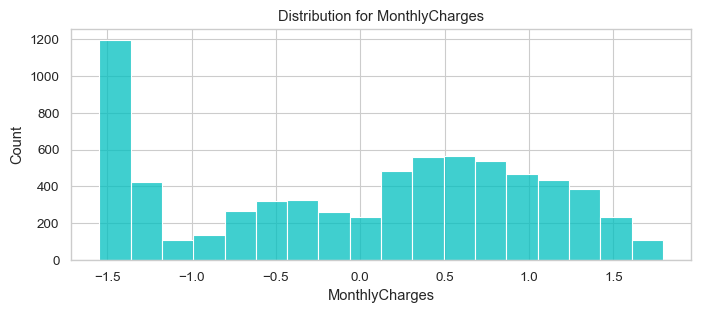

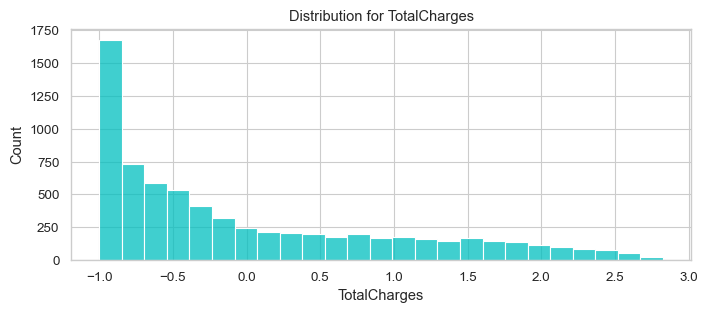

In [329]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')), columns=num_cols)
for feat in numerical_cols: distplot(feat, df_std, color='c')

standardize numeric values

In [330]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [331]:
feature_names = X_train.columns.tolist()

In [332]:
def outerCV(model, X_train, y_train, model_name):
    # Outer CV for robust performance estimation
    print("\nRunning nested cross-validation for unbiased evaluation...")
    nested_scores = cross_validate(
        model,
        X_train, y_train,
        cv=outer_cv,
        scoring=scoring,
        n_jobs=-1
    )

    print(f"\nNested CV Results ({model_name}):")
    for metric in scoring:
        scores = nested_scores[f'test_{metric}']
        print(f"{metric.upper()}: {scores.mean():.4f} ± {scores.std():.4f}")
    return nested_scores


def predict_result(model, model_name, X_test, y_test):
    # Get best estimator
    best = model.best_estimator_

    # Predictions
    predicted_y = best.predict(X_test)
    y_pred_prob = best.predict_proba(X_test)[:, 1]

    # Final metrics
    accuracy = best.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_prob)

    print(f"\nFinal Test Performance {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predicted_y))
    return best, predicted_y


def show_confusion_matrix(test, predicted_y, model_name):
    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        confusion_matrix(test, predicted_y),
        annot=True,
        fmt="d",
        linecolor="k",
        linewidths=3,
        cmap="Blues"
    )
    plt.title(f"{model_name.upper()} CONFUSION MATRIX", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


def show_ROC(best, X_test, y_test, model_name):
    y_pred_prob = best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # use roc_auc_score
    auc_test = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_test:.3f})', color="r", linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name.upper()} ROC CURVE', fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def importance_feature(best, model_name):
    importances = best.feature_importances_
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print(importance.head(10))

    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance.head(10), x='importance', y='feature')
    plt.title(f'{model_name} Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Model

set cross validation

In [333]:
# Define outer CV (for unbiased performance estimation)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
# Define inner CV (for hyperparameter tuning)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
scoring = ['roc_auc', 'f1', 'recall', 'precision']

## Knn

In [334]:
np.random.seed(325)
# Define KNN model
knn_model = KNeighborsClassifier()

knn_name = 'knn'

# Define hyperparameter search space
param_dist_knn = {
    'n_neighbors': np.arange(3, 31, 2),  # search from 3 to 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Set up randomized search with INNER CV
knn_random = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=30,  # try 30 random combinations
    cv=inner_cv,
    scoring='roc_auc',  # optimize for AUC
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Fit on training data
knn_random.fit(X_train, y_train)

print("Best KNN parameters:", knn_random.best_params_)
print("Best CV AUC:", knn_random.best_score_)

Best KNN parameters: {'weights': 'uniform', 'n_neighbors': np.int64(29), 'metric': 'euclidean'}
Best CV AUC: 0.8245044827438512


In [335]:
nested_scores_knn = outerCV(knn_random, X_train, y_train, knn_name)


Running nested cross-validation for unbiased evaluation...

Nested CV Results (knn):
ROC_AUC: 0.8258 ± 0.0103
F1: 0.5814 ± 0.0251
RECALL: 0.5558 ± 0.0329
PRECISION: 0.6105 ± 0.0249


In [336]:
best_knn, predicted_knn_y = predict_result(knn_random, knn_name, X_test, y_test)


Final Test Performance knn:
Accuracy: 0.7900
AUC: 0.8419

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1549
           1       0.61      0.60      0.60       561

    accuracy                           0.79      2110
   macro avg       0.73      0.73      0.73      2110
weighted avg       0.79      0.79      0.79      2110



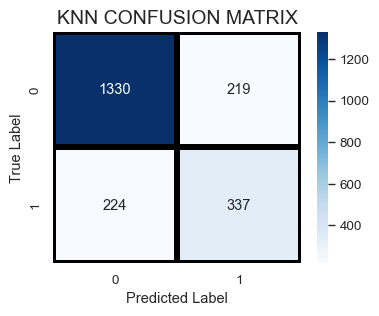

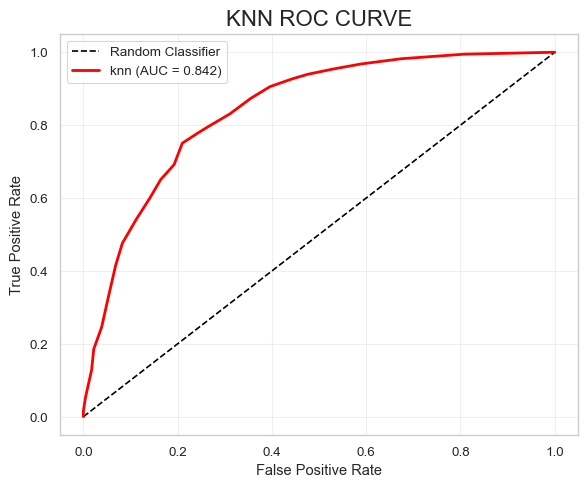

In [337]:
show_confusion_matrix(y_test, predicted_knn_y, knn_name)
show_ROC(best_knn, X_test, y_test, knn_name)

## Svm

In [338]:
np.random.seed(325)
# Train SVM model WITH probability=True (required for predict_proba)
svc_model = SVC(probability=True, random_state=1)

svm_name = 'svm'

param_dist_svm = {
    'C': np.logspace(-1, 1, 10),  # 缩小范围
    'gamma': ['scale'] + list(np.logspace(-2, 0, 10)),
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

svm_search = RandomizedSearchCV(
    svc_model,
    param_distributions=param_dist_svm,
    n_iter=30,  # balance quality vs. time
    scoring='roc_auc',  # appropriate for imbalanced data
    cv=inner_cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("Tuning SVM hyperparameters...")
svm_search.fit(X_train, y_train)
print("\nBest SVM Parameters:")
print(svm_search.best_params_)
print("Best CV AUC:", round(svm_search.best_score_, 4))

Tuning SVM hyperparameters...

Best SVM Parameters:
{'kernel': 'rbf', 'gamma': np.float64(0.016681005372000592), 'class_weight': 'balanced', 'C': np.float64(0.16681005372000587)}
Best CV AUC: 0.8315


In [339]:
nested_scores_svm = outerCV(svm_search, X_train, y_train, svm_name)
best_svm, predicted_svm_y = predict_result(svm_search, svm_name, X_test, y_test)


Running nested cross-validation for unbiased evaluation...

Nested CV Results (svm):
ROC_AUC: 0.8332 ± 0.0072
F1: 0.6049 ± 0.0188
RECALL: 0.8066 ± 0.0149
PRECISION: 0.4844 ± 0.0231

Final Test Performance svm:
Accuracy: 0.7436
AUC: 0.8568

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1549
           1       0.51      0.84      0.63       561

    accuracy                           0.74      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.74      0.76      2110



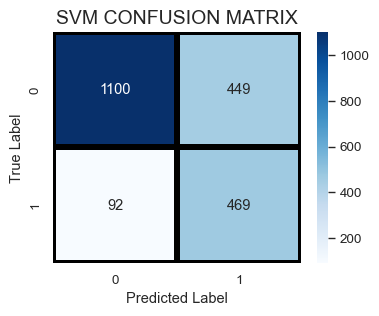

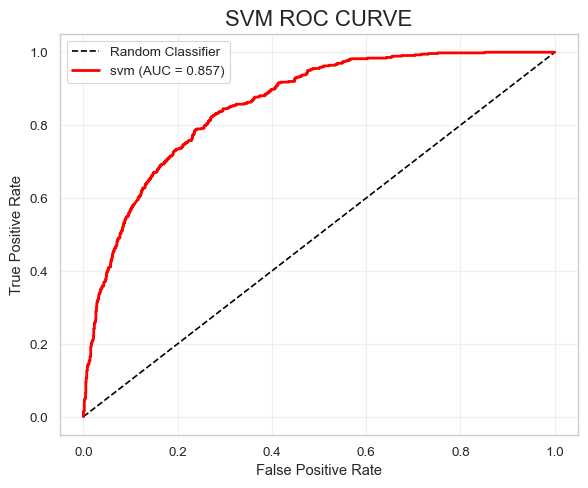

In [340]:
show_confusion_matrix(y_test, predicted_svm_y, svm_name)
show_ROC(best_svm, X_test, y_test, svm_name)

## Ramdom tree

In [341]:
np.random.seed(325)
# Train Random Forest model
rt_model = RandomForestClassifier(
    n_jobs=-1,
    random_state=50
)
random_tree = 'random_tree'

# Focus on key parameters that impact performance & overfitting
param_dist_rt = {
    'n_estimators': [100, 200, 500, 800, 1000],
    'max_depth': [3, 5, 8, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}

# HYPERPARAMETER TUNING
rt_search = RandomizedSearchCV(
    rt_model,
    param_distributions=param_dist_rt,
    n_iter=40,
    scoring='roc_auc',
    cv=inner_cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Fit on training data
print("Tuning Random Forest hyperparameters...")
rt_search.fit(X_train, y_train)

print("\nBest Random Forest Parameters:")
print(rt_search.best_params_)
print("Best CV AUC:", round(rt_search.best_score_, 4))

Tuning Random Forest hyperparameters...

Best Random Forest Parameters:
{'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}
Best CV AUC: 0.84


In [342]:
nested_scores_rt = outerCV(rt_search, X_train, y_train, random_tree)
best_rt, predicted_rt_y = predict_result(rt_search, random_tree, X_test, y_test)


Running nested cross-validation for unbiased evaluation...

Nested CV Results (random_tree):
ROC_AUC: 0.8425 ± 0.0076
F1: 0.5629 ± 0.0317
RECALL: 0.4904 ± 0.0342
PRECISION: 0.6619 ± 0.0356

Final Test Performance random_tree:
Accuracy: 0.8123
AUC: 0.8577

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1549
           1       0.69      0.54      0.61       561

    accuracy                           0.81      2110
   macro avg       0.77      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110



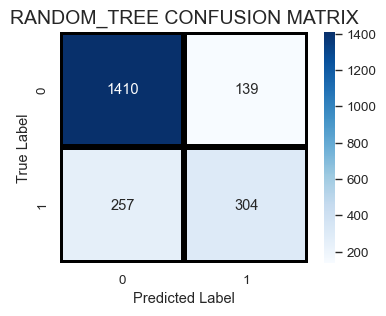

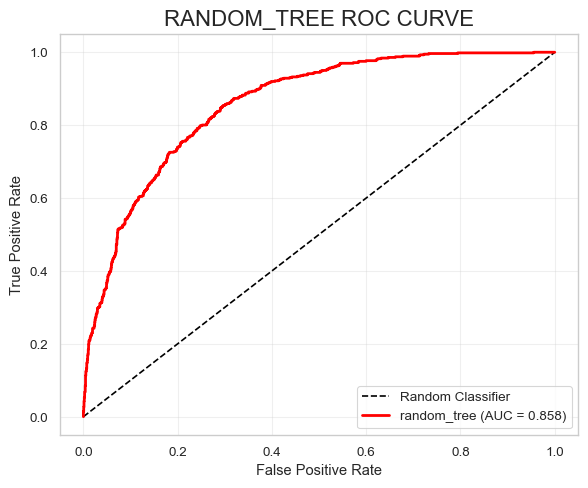

In [343]:
show_confusion_matrix(y_test, predicted_rt_y, random_tree)
show_ROC(best_rt, X_test, y_test, random_tree)

                           feature  importance
4                           tenure    0.152099
33         Contract_Month-to-month    0.130005
8                     TotalCharges    0.114036
7                   MonthlyCharges    0.076045
24                  TechSupport_No    0.062623
15               OnlineSecurity_No    0.061345
38  PaymentMethod_Electronic check    0.058670
13     InternetService_Fiber optic    0.052664
35               Contract_Two year    0.042736
12             InternetService_DSL    0.023842


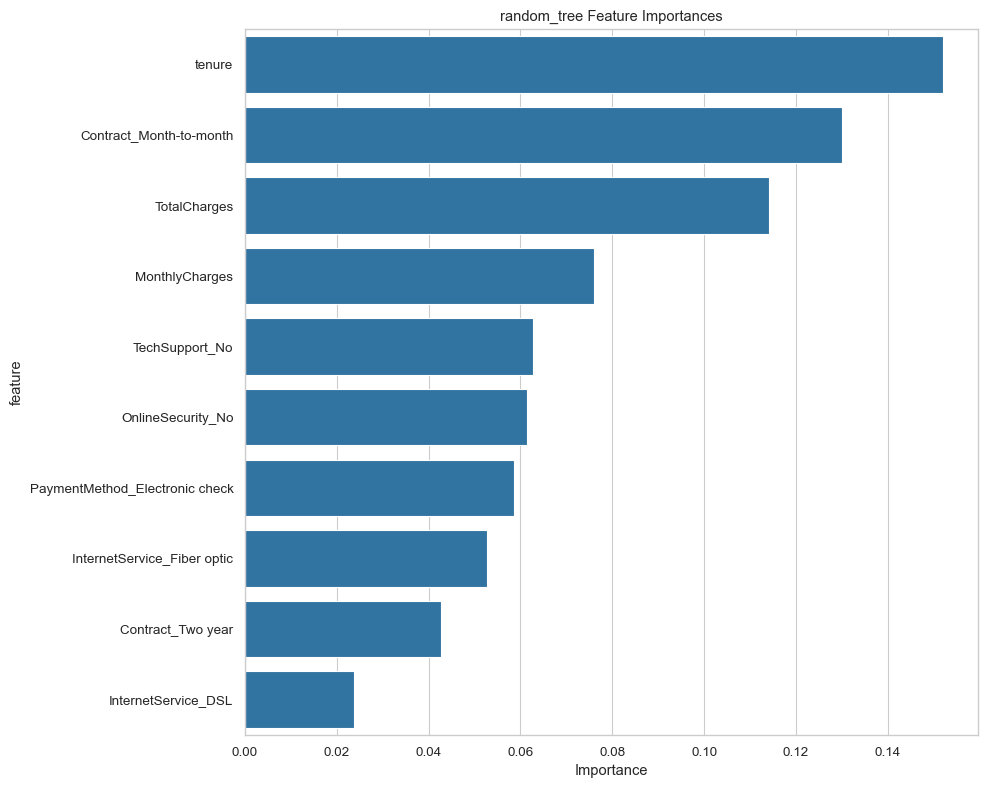

In [344]:
importance_feature(best_rt, random_tree)

## logistic regression

In [345]:
np.random.seed(325)
# Train Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Prevent convergence warnings
    solver='liblinear'  # for small datasets & supports L1/L2
)

lr_name = 'Logistic Regression'

# Hyperparameter grid
param_dist_lr = {
    'C': np.logspace(-4, 4, 50),
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']  # for imbalanced churn data
}

lr_search = RandomizedSearchCV(
    lr_model,
    param_distributions=param_dist_lr,
    n_iter=40,
    scoring='roc_auc',  # 'f1' if recall/precision balance is key
    cv=inner_cv,
    n_jobs=-1,
    random_state=42
)

# Fit on scaled training data
print("Tuning Logistic Regression hyperparameters...")
lr_search.fit(X_train, y_train)

print("\nBest Logistic Regression Parameters:")
print(lr_search.best_params_)
print("Best CV AUC:", round(lr_search.best_score_, 4))

Tuning Logistic Regression hyperparameters...

Best Logistic Regression Parameters:
{'penalty': 'l1', 'class_weight': None, 'C': np.float64(16.768329368110066)}
Best CV AUC: 0.8377


In [346]:
nested_scores_lr = outerCV(lr_search, X_train, y_train, lr_name)
best_lr, predicted_lr_y = predict_result(lr_search, lr_name, X_test, y_test)


Running nested cross-validation for unbiased evaluation...

Nested CV Results (Logistic Regression):
ROC_AUC: 0.8396 ± 0.0104
F1: 0.5913 ± 0.0270
RECALL: 0.5619 ± 0.0887
PRECISION: 0.6394 ± 0.0479

Final Test Performance Logistic Regression:
Accuracy: 0.8118
AUC: 0.8579

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1549
           1       0.67      0.58      0.62       561

    accuracy                           0.81      2110
   macro avg       0.76      0.74      0.75      2110
weighted avg       0.81      0.81      0.81      2110



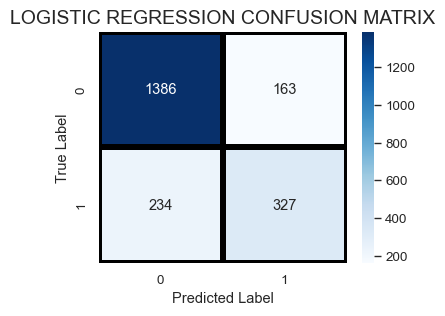

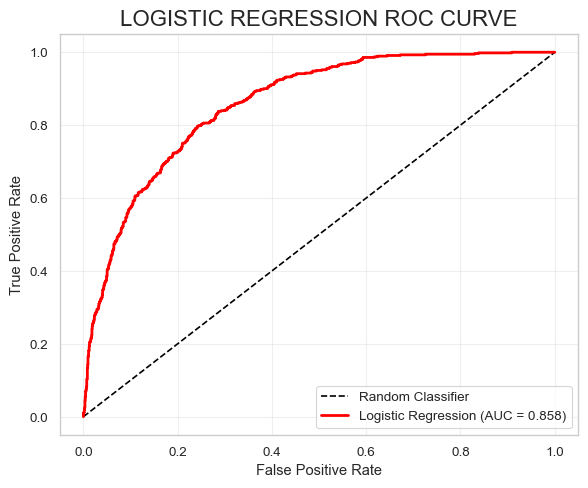

In [347]:
show_confusion_matrix(y_test, predicted_lr_y, lr_name)
show_ROC(best_lr, X_test, y_test, lr_name)

## Decision tree

In [348]:
np.random.seed(325)
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)  # added for reproducibility

dt_name = 'Decision Tree'

# 2. DEFINE HYPERPARAMETER SEARCH SPACE
# Prevent overfitting by limiting depth, nodes, and samples per leaf
param_dist_dt = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']  # Important for imbalanced churn data
}

dt_search = RandomizedSearchCV(
    dt_model,
    param_distributions=param_dist_dt,
    n_iter=50,  # Decision Trees are fast → more trials
    scoring='roc_auc',
    cv=inner_cv,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
print("Tuning Decision Tree hyperparameters...")
dt_search.fit(X_train, y_train)

print("\nBest Decision Tree Parameters:")
print(dt_search.best_params_)
print("Best CV AUC:", round(dt_search.best_score_, 4))

Tuning Decision Tree hyperparameters...

Best Decision Tree Parameters:
{'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best CV AUC: 0.802


In [349]:
nested_scores_dt = outerCV(dt_search, X_train, y_train, dt_name)
best_dt, predicted_dt_y = predict_result(dt_search, dt_name, X_test, y_test)


Running nested cross-validation for unbiased evaluation...

Nested CV Results (Decision Tree):
ROC_AUC: 0.8079 ± 0.0139
F1: 0.5984 ± 0.0151
RECALL: 0.7752 ± 0.0242
PRECISION: 0.4875 ± 0.0151

Final Test Performance Decision Tree:
Accuracy: 0.7303
AUC: 0.8257

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1549
           1       0.50      0.81      0.61       561

    accuracy                           0.73      2110
   macro avg       0.70      0.75      0.70      2110
weighted avg       0.80      0.73      0.75      2110



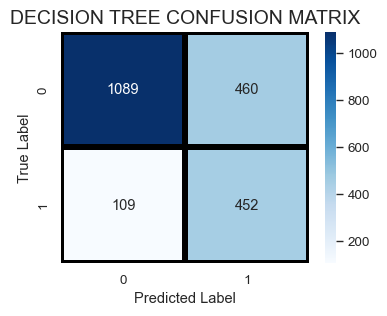

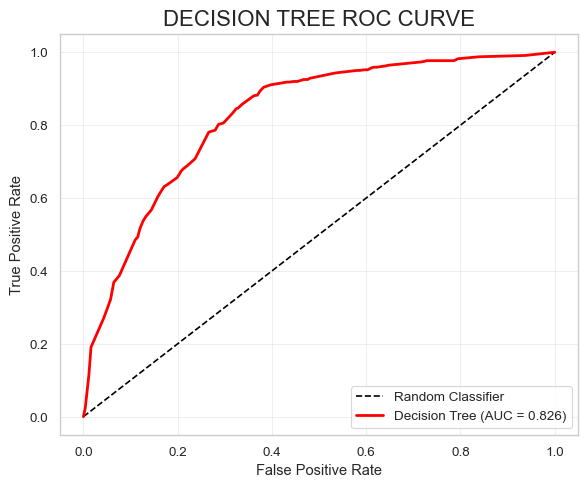

In [350]:
show_confusion_matrix(y_test, predicted_dt_y, dt_name)
show_ROC(best_dt, X_test, y_test, dt_name)

                                feature  importance
18                      OnlineBackup_No    0.202894
8                          TotalCharges    0.183113
33              Contract_Month-to-month    0.164277
38       PaymentMethod_Electronic check    0.113409
7                        MonthlyCharges    0.073516
35                    Contract_Two year    0.046893
4                                tenure    0.041449
31  StreamingMovies_No internet service    0.030123
21                  DeviceProtection_No    0.027065
34                    Contract_One year    0.020326


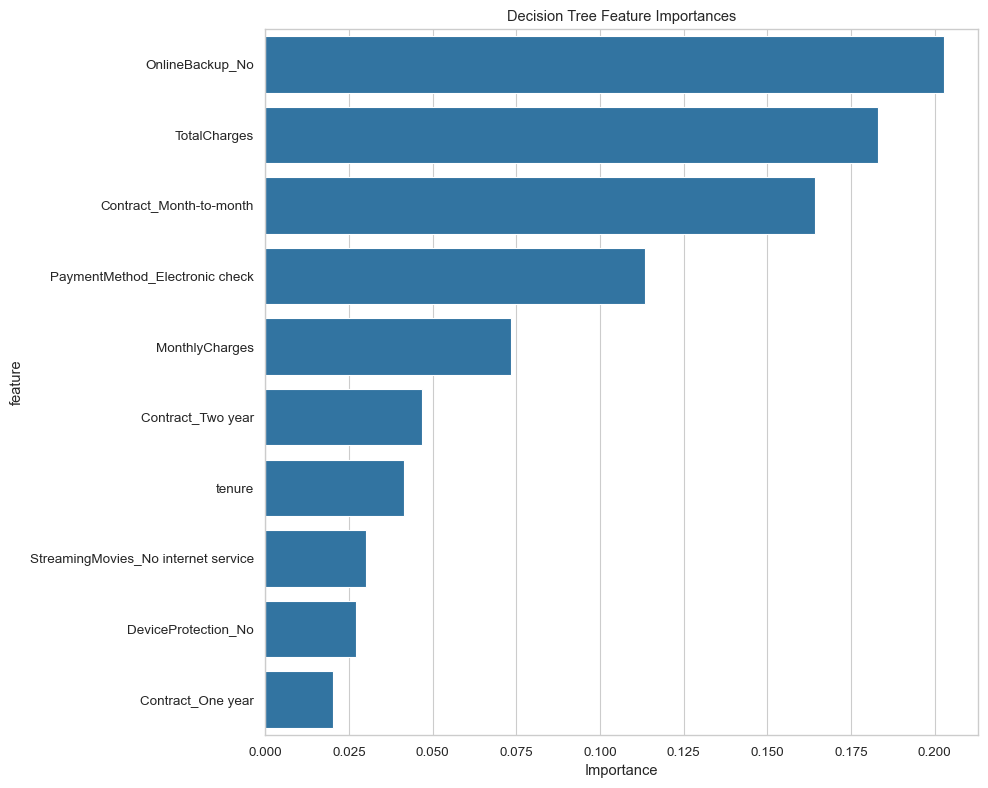

In [351]:
importance_feature(best_dt, dt_name)

## Save models

In [352]:
import joblib

joblib.dump(best_knn, 'models/knn_model.pkl')
joblib.dump(best_svm, 'models/svm_model.pkl')
joblib.dump(best_rt, 'models/rf_model.pkl')
joblib.dump(best_lr, 'models/lr_model.pkl')
joblib.dump(best_dt, 'models/dt_model.pkl')

['models/dt_model.pkl']

# Compare models

In [353]:
def summarize_nested_cv(cv_results, model_name):
    summary = {'Model': model_name}
    for metric in ['roc_auc', 'f1', 'recall', 'precision']:
        key = f'test_{metric}'
        summary[f'{metric.upper()} (mean)'] = np.mean(cv_results[key])
        summary[f'{metric.upper()} (std)'] = np.std(cv_results[key])
    return summary


# Build comparison table
comparison_data = [
    summarize_nested_cv(nested_scores_knn, 'KNN'),
    summarize_nested_cv(nested_scores_svm, 'SVM'),
    summarize_nested_cv(nested_scores_rt, 'Random Forest'),
    summarize_nested_cv(nested_scores_lr, 'Logistic Regression'),
    summarize_nested_cv(nested_scores_dt, 'Decision Tree')
]

results_df = pd.DataFrame(comparison_data).round(4)
results_df.set_index('Model', inplace=True)
print(results_df)

                     ROC_AUC (mean)  ROC_AUC (std)  F1 (mean)  F1 (std)  \
Model                                                                     
KNN                          0.8258         0.0103     0.5814    0.0251   
SVM                          0.8332         0.0072     0.6049    0.0188   
Random Forest                0.8425         0.0076     0.5629    0.0317   
Logistic Regression          0.8396         0.0104     0.5913    0.0270   
Decision Tree                0.8079         0.0139     0.5984    0.0151   

                     RECALL (mean)  RECALL (std)  PRECISION (mean)  \
Model                                                                
KNN                         0.5558        0.0329            0.6105   
SVM                         0.8066        0.0149            0.4844   
Random Forest               0.4904        0.0342            0.6619   
Logistic Regression         0.5619        0.0887            0.6394   
Decision Tree               0.7752        0.0242      

In [354]:
# Melt for plotting
melted = results_df.reset_index().melt(
    id_vars='Model',
    value_vars=['ROC_AUC (mean)', 'F1 (mean)', 'RECALL (mean)'],
    var_name='Metric',
    value_name='Score'
)

# Clean metric names
melted['Metric'] = melted['Metric'].str.replace(' (mean)', '')

fig = px.bar(
    melted,
    x='Model',
    y='Score',
    color='Metric',
    barmode='group',
    title='Model Comparison (Nested CV Mean Performance)',
    height=500,
    text_auto=True
)
fig.update_layout(yaxis_range=[0, 1], font=dict(size=12))
fig.show()

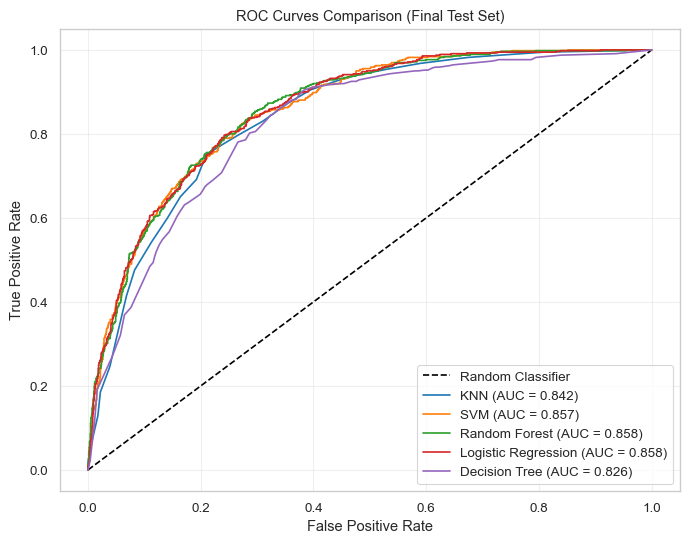

In [355]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

models_final = {
    'KNN': best_knn,
    'SVM': best_svm,
    'Random Forest': best_rt,
    'Logistic Regression': best_lr,
    'Decision Tree': best_dt
}

# For SVM and LR, use scaled test data!
X_test_dict = {
    'KNN': X_test,
    'SVM': X_test,
    'Random Forest': X_test,
    'Logistic Regression': X_test,
    'Decision Tree': X_test
}

for name, model in models_final.items():
    X_input = X_test_dict[name]
    y_pred_prob = model.predict_proba(X_input)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Final Test Set)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()